<a id='contents'><h2>Contents</h2></a>

[Getting images out of Doug's raster pipeline](#dougOut)

[Digitizing polygons](#digPol)
- [A detour that kinda went nowhere: GIMP](#deadGimp)
- [Digitizing with scikit-image](#skimmage)

[Get back to Matlab](#Py2Mat)

[Messing around with polygons](#messAround)

---
<a id='dougOut'><h3>Getting images out of Doug's raster pipeline</h3></a>

Let's dive back into the process of making polygons from Doug's processed photos. Flower photos were broken into their various petals of interest, and color differences were maximized by categorizing all pixels into three color poles using kmeans clustering. A "bottom" petal, for instance looks like this, after Doug's pipeline (converted to grayscale):

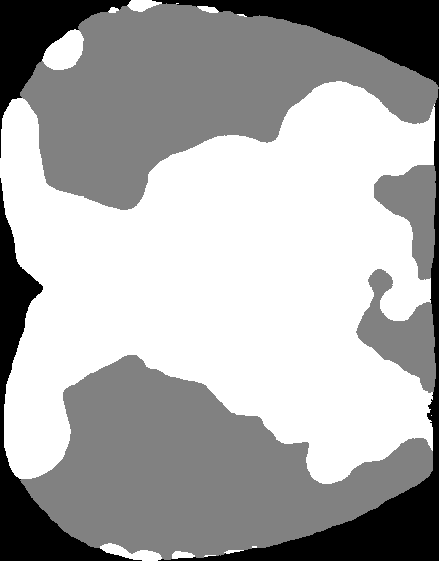

In [1]:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
pkg load image
aa = mat2gray(Petals.Clusters.right);
imshow(aa) %% that works.

We want to make polygons of spots and their petals. We can begin by "peeling" these two apart into separate, solid-black images:

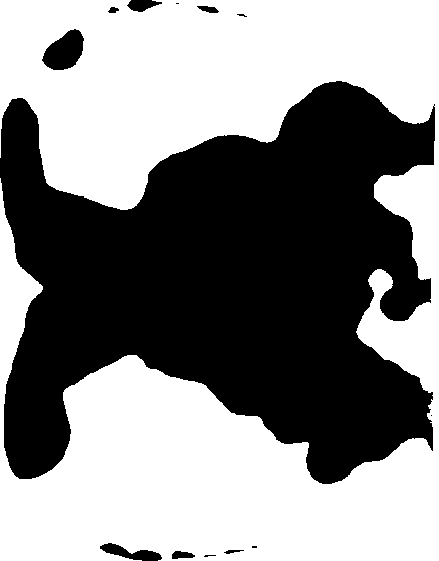

In [2]:
bb = aa < 1;
imshow(bb);


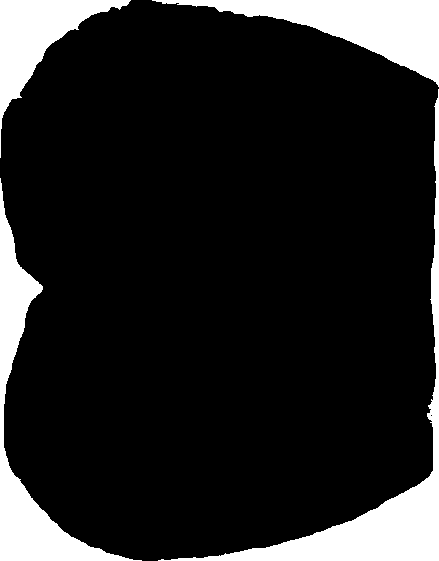

In [3]:
cc = aa == 0;
imshow(cc);

We save these and export them for gimp...

In [4]:
imwrite(bb, 'P431F1_bottom_spots.png')
imwrite(cc, 'P431F1_bottom_petal.png')

We can generalize the above process, to get all of the available photos from Doug's efforts into a form ready to digitized. I wrote a matlab script for this:

In [1]:
cat prepDougRasters.m

%%%%%%%%%%%%%%%%%%%%%%%%%%

%% a script to put all of Doug's rasters into a form we can use:

%% go to working directory
wd = '/Users/danthomas/Documents/speckling/make_polygons/polygons/';
cd(wd);

dougRasterDir = "/Users/danthomas/Documents/speckling/dougRaster/Rotated_and_Cropped/";

cd(dougRasterDir)

files = dir('P*.mat');
for file = files';
    im = file.name;
    imName = regexprep(im,'\.mat', ''); 
    %% go get our file, come back
    cd(dougRasterDir);
    rast=load(im);
    cd(wd);
    %% make a spot for our image, go to it:
    mkdir(imName);
    cd (imName);
    %% get our petal names (left, right mid)
    petNames = fieldnames(rast.Petals.Clusters);
    %% split images into petal and spot, export, for each of the three petals:
    for i = 1:length(petNames);
        pet = rast.Petals.Clusters.(petNames{i}); %petal at hand
        rastGray = mat2gray(pet); 
        spots = rastGray  < 1; 
        petal = rastGray == 0;
        mkdir(petNames{i});
        cd(petNames{i});
 

This is brittle code, if the file architecture of the repo or the shape of Doug's matlab structures changes, it will break. But most of it should be useful/re-useable, so including it here. 

---

<a id='digPol'><h3>Digitizing polygons</h3></a>

<a id='deadGimp'><h4>A detour that kinda went nowhere: GIMP</h4></a>

Leave matlab/octave for a moment. For posterity I'll record a dead-end here. This didn't work but it was some effort, so maybe some this will be useful at some point. 

I tried to use [GIMP](https://www.gimp.org/) for detecting the edges of these black-and-white images we've created. Gimp has a command line mode that can run scripts. I wrote a script in GIMP's scriptfu language to export an svg of the edges of these petal and spot shapes:

In [2]:
cat makePetalPoly.scm

(define(makePetalPoly filename)
    (let* (
            ;; load files, set vars
            (image (car (gimp-file-load 
                                0 
                                filename 
                                filename
                        ) 
                    ) 
            )
            (drawable (car (gimp-image-get-active-layer image)))
            (outPut (string-append filename "_path.svg"))
          )
            ;; do stuff
            ;;1 select black/solid regions:
            (gimp-image-select-color 
                image
                CHANNEL-OP-REPLACE
                drawable
                '(0 0 0) ;; black
            )
            ;;2 Convert selection to path
            (plug-in-sel2path
                RUN-NONINTERACTIVE
                image
                drawable
            ) 
            ;;3 save path to file
        (gimp-vectors-export-to-file
            image
            ;"/Users/danthomas/Documents/speckling/make_polygons/spo

---
To use this script, place it in one of the directories that GIMP uses for scripts. In gimp 2.8, you can find this by looking in `Edit --> Preferences --> Folders --> Scripts. `

On my Ubuntu machine we use GIMP and the script like this:

In [3]:
gimp -i -b '(makePetalPoly "P431F1_bottom_spots.png")' -b '(gimp-quit 0)'


(gimp:1249): GLib-GObject-WARNING **: g_object_set_valist: object class 'GeglConfig' has no property named 'cache-size'

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD4940 from "gimp:point-layer-mode" to "gimp:dissolve-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD4D50 from "gimp:point-layer-mode" to "gimp:behind-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD50F0 from "gimp:point-layer-mode" to "gimp:multiply-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD6200 from "gimp:point-layer-mode" to "gimp:screen-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD65D0 from "gimp:point-layer-mode" to "gimp:overlay-mode"

(gimp:1249): GEGL-gegl-operation.c-WARNING **: Cannot change name of operation class 0x2CD6A00 from "gimp:point-layer-mode" to "gimp:diffe

Not sure about the GEGL-related warnings. But this then gives us an svg made of bezier curves:

![](P431F1_bottom_spots.png_path.svg)

This looks quite nice. Unfortunately, I haven't yet figured out how to conserve these nice curves in some form that matlab will accept as polygons. We can flattened these curves by removing their control points and converting them to lines. We can do this with a big regex in SED (which might have to be modified for mac OS SED):

In [5]:
cp P431F1_bottom_spots.png_path.svg test.svg
sed '/^\s*C/ s/C\s/L /' test.svg | \
sed -e 's/\([0-9]*\.[0-9]*,[0-9]*\.[0-9]*\) \([0-9]*\.[0-9]*,[0-9]*\.[0-9]*\) \([0-9]*\.[0-9]*,[0-9]*\.[0-9]*\)/\1/g' > test2.svg

![](test2.svg)

This is a less than perfect solution, so let's spend more time on this. 

---

<a id='skimmage'><h4>Digitizing with scikit-image</h4></a>

So let's drop the GIMP idea and try some software that's more intended for this kind of work. Let's see if a quick dip into python, in particular [scikit-image](https://scikit-image.org/), can help us. 

But first, let's get example images out of matlab/octave again:

In [1]:
## in octave:
pkg load image

## get one grayscale image:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
aa = mat2gray(Petals.Clusters.right);

## remake our images:
spots = aa < 1;

petal = aa == 0;

## save them as csv's:

csvwrite('P431F1petal.csv',petal)
csvwrite('P431F1spots.csv',spots)

Then see if we can visualize them in Python:

In [1]:
## python
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, filters, measure

petal = np.genfromtxt ('P431F1petal.csv', delimiter=",")
spots = np.genfromtxt ('P431F1spots.csv', delimiter=",")

The contour module should be able to outline these spots and break them up into their individual polygons.

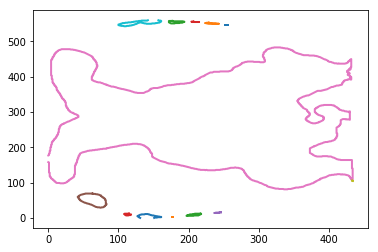

In [2]:
contours = measure.find_contours(spots, 0)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

#plt.show()

Close! Looks like the contours are being interrupted by our borders: 

In [4]:
## to add one pixel of white to columns:
spots_marg = np.insert(spots, 439, 1, 1)
spots_marg = np.insert(spots_marg, 0, 1, 1)
## and rows:
spots_marg = np.insert(spots_marg, 561, 1, 0)
spots_marg = np.insert(spots_marg, 0, 1, 0)

To keep the relative positions accurate, we have to do the the same with the petal outline:

In [5]:
petal_marg = np.insert(petal, 439, 1, 1)
petal_marg = np.insert(petal_marg, 0, 1, 1)
petal_marg = np.insert(petal_marg, 561, 1, 0)
petal_marg = np.insert(petal_marg, 0, 1, 0)

Does this help?

In [6]:
Pcontours = measure.find_contours(petal_marg, 0)
contours = measure.find_contours(spots_marg, 0)

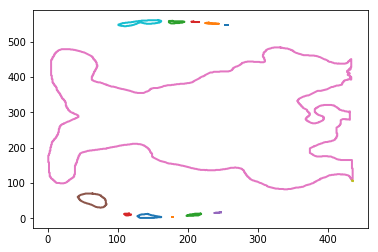

In [8]:
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

Looks like the polygons closed. With the petal outline:

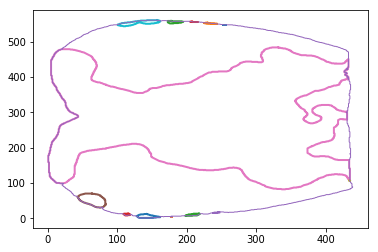

In [10]:
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.plot(Pcontours[0][:,1], Pcontours[0][:,0], linewidth=1)

In [1]:
photoname = 'P431F1'
partname  = 'spots'
petalname = 'bottom'

for n, contour in enumerate(contours):
    polyname = photoname + petalname + partname + str(n) + "_poly.csv"
    np.savetxt(fname=polyname, X=contour.astype(int), delimiter=',')

Looks good. Are these in a format that Matlab/Octave can parse? Back into Matlab:

In [15]:
%% switch to Matlab kernel
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter

In [17]:
a=csvread('P431F1bottomspots6_poly.csv');
b=polyshape(a) %% doesn't like that we repeat our last vertex, but deals with it

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

b = 

  polyshape with properties:

      Vertices: [971x2 double]
    NumRegions: 1
      NumHoles: 0



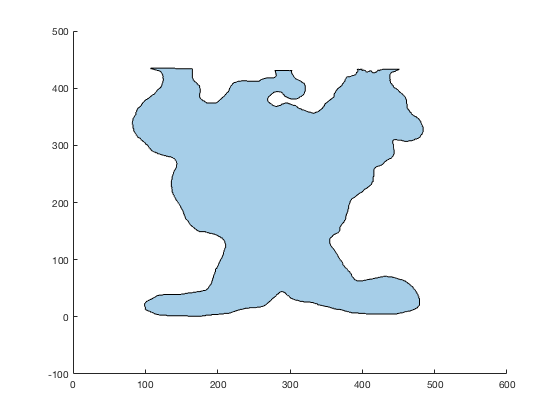

In [19]:
plot(b)

Okay! looks like matlab can parse our polygons that we make with python. Let's go back and make a nicer script that can handle some volume and that can be run from the command line...

This script is saved in the repo, but here's a look at it:

In [3]:
cat get_pols.py

#!/usr/bin/env python3

import argparse, os
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, filters, measure

## instantiate the argparser
parser = argparse.ArgumentParser()
## deal with arguments:
parser.add_argument('file', 
            help="Name of the .csv file from matlab that contains grayscale information about a petal.")
args = parser.parse_args()

## get our image in...
aa  = np.genfromtxt(args.file, delimiter = ",")

## set up our directory for saving files

## name of raster image (a petal or a spots grayscale matrix from matlab)
imageName = args.file[:-4] ## no file extension
#imageName = argsfile[:-4] ## no file extension


## name of folder, based on image
cwd = os.getcwd()
fullFolderName = cwd + "/" + os.path.basename(imageName)
## make a new directory for the CSVs
## we will make at the end of all this:
os.makedirs(fullFolderName, exist_ok=True)

aR = aa.shape[0] ## number of rows
aC = aa.shape[1] ## number of cols

## add one pixel of 

So we can run this on one of our black-and-white CSVs that we got from doug's pipeline [(above)](#dougOut)

`./get_pols.py P431F1spots.csv` 

`./get_pols.py P431F1petals.csv`

This creates two folders one with polygons from our spots, and one with just one file, of the outline of our petal. Let's look at them with Matlab:

In [7]:
%% switch to Matlab kernel
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter

In [1]:
%% some name variables, trying to set up for scripting a function 
wkd = '/Users/danthomas/Documents/speckling/make_polygons/';
name='P431F1spots';

cd(wkd);
cd(name);

We can read in those csvs we just made in python:

In [4]:
aa = struct;
counter = 1;
files = dir('*.csv');
for file = files';
    coords = csvread(file.name);
    aa(counter).coords=coords;
    counter = counter + 1;
end;

For spots with enough points we can turn these into polygons. As before, polyshape() doesn't like the fact that scikit-image closes it's polygons with a repeated last vertex. But it deals with it:

In [5]:
counter=1;
for i = aa;
    if length(i.coords(:,1)) > 3;
        aa(counter).p = polyshape(i.coords)
    end;
    counter=counter+1;
end;

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 411)
  In polyshape (line 155)
> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)

aa = 

  1x14 struct array with fields:

    coords
    p

> In polyshape/checkAndSimpl

Plot these:

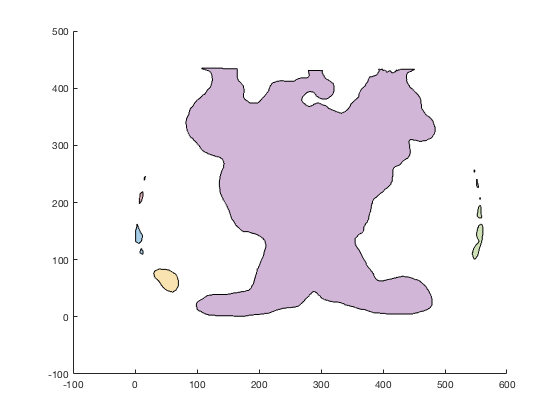

In [8]:
counter=1;
for i = aa;
    if ~isempty(i.p)
        plot(i.p)
        hold on %% keep the plot open
    end;
    counter=counter+1;
end;

> In polyshape/checkAndSimplify (line 421)
  In polyshape (line 155)


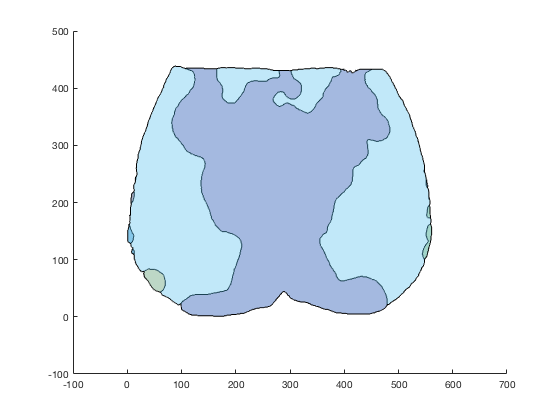

In [10]:
%% add our petal outline:

counter=1;
for i = aa;
    if ~isempty(i.p)
        plot(i.p)
        hold on %% keep the plot open
    end;
    counter=counter+1;
end;

Pcoords = csvread("/Users/danthomas/Documents/speckling/make_polygons/P431F1petal/P431F1petal_poly0.csv");
Ppoly = polyshape(Pcoords);
plot(Ppoly)


Lots work to be done, and some decisions to be made. Some tiny spots are being lost - how much do we care about this little ones? This needs to be talked about. But to apply our script across the numerous images, in the file architecture of my repo, we start a new container directory, put a copy of get_pols.py in it and use `find`.

In [ ]:
#find ../polygons/ -name "P*csv" -type f  -exec ./get_pols.py {} \;

<a id='Py2Mat'><h3>Get back to Matlab</h3></a>

The result is a LOT of .csv files (1000's)! Let's simplify by combining into substructures of Doug's existing Matlab structures for these images. In matlab:

In [ ]:
wd = '/Users/danthomas/Documents/speckling/make_polygons/';
petNames = ["left", "mid", "right"];
typPols = ["petal", "spots"];

%% go to the images/structures folder and get out a list of all the *mat files:
cd(dougdir)
hs = dir('P*.mat');
for h = hs'; %% for each mat file:
    im = regexprep(h.name,'\.mat', '');
    cd(wd)
    Polys = struct; %% empty struct to hold the polyshapes
    for i = petNames; %% left, mid, right
        for j = typPols; %% petal/spots
            imdir = "tryScript/" + im + "_" + i + "_" + j; %% this is where all our csvs are
            cd(imdir);
            files = dir('P*.csv');
            counter = 1;
            for file = files';
                disp(file.name)
                disp(counter)
                coords=csvread(file.name);
                if length(coords(:,1)) > 3; %% if there are enough points
                    Polys.(i).(j)(counter) = polyshape(coords); %% convert to polyshape
                    counter=counter+1;
                end;
            end;
        cd(wd)
        end;
    end;
    load(dougdir + im + ".mat"); %% get doug's matlab structure
    Petals.Polys = Polys; %% add our new Polys structure inside it
    imFile = wd + "matObjW_pol/" + im + ".mat"; %% save the modified structure
    save(imFile,"Petals");
end;


This adds our polygons as fields to dougs original matlab structure objects. Just to pick one and visualize:

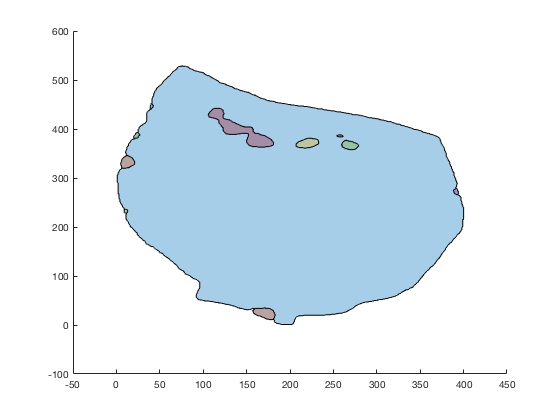

In [2]:
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter
load("/Users/danthomas/Documents/speckling/make_polygons/matObjW_pol/P440F1.mat")

%% iterate through our petal outline and spots

for i = Petals.Polys.left.petal
    if ~isempty(i)
        plot(i)
        hold on %% keep the plot open
    end;
end;

for i = Petals.Polys.left.spots
    if ~isempty(i)
        plot(i)
        hold on %% keep the plot open
    end;
end;

We want some nice graphical summary of this pipeline, from jpeg to Doug's 3-color objects to these petal/spot polygons. Something like:

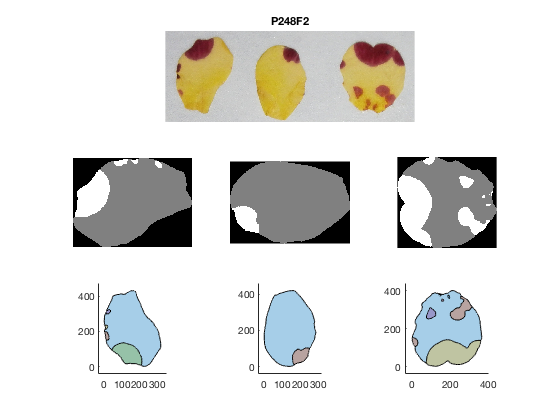

In [3]:
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter

%% get the working env organized:
wd="/Users/danthomas/Documents/speckling/make_polygons/matObjW_pol";
cd(wd);
load('P248F2.mat');
dougdir = "/Users/danthomas/Documents/speckling/dougRaster/Rotated_and_Cropped/";
[a,b,c] = fileparts(Petals.fullName);
jpegName = char(dougdir + b + c); %% gotta be a character object?

%% plot a page:
    figure;
    %%%%%%%%% first row %%%%%%%%%%%%%%%
    subplot(3,3,[1,3]);
    imshow(jpegN);
    title(b) %% this is our plot title
    %%%%%%%%% second row %%%%%%%%%%%%%
    subplot(3,3,4);
    aa = mat2gray(Petals.Clusters.left);
    imshow(aa)
    subplot(3,3,5);
    aa = mat2gray(Petals.Clusters.mid);
    imshow(aa)
    subplot(3,3,6);
    aa = mat2gray(Petals.Clusters.right);
    imshow(aa)
    %%%%%%%%%% third row %%%%%%%%%%%%%%
    subplot(3,3,7);
        if isfield(Petals.Polys.left,'petal');
        for i = Petals.Polys.left.petal;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        if isfield(Petals.Polys.left,'spots');
        for i = Petals.Polys.left.spots;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        daspect([1 1 1])
    subplot(3,3,8);
        if isfield(Petals.Polys.mid,'petal');
        for i = Petals.Polys.mid.petal;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        if isfield(Petals.Polys.mid,'spots');
        for i = Petals.Polys.mid.spots;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        daspect([1 1 1])
    subplot(3,3,9);
        if isfield(Petals.Polys.right,'petal');
        for i = Petals.Polys.right.petal;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        if isfield(Petals.Polys.right,'spots');
        for i = Petals.Polys.right.spots;
            if ~isempty(i);
                plot(i);
                hold on %% keep the plot open;
            end;
        end; end;
        daspect([1 1 1])
    %%%%%%%%%%%%%%

True matlab programmers will gag at this. But I'm no matlab programmer, I have no standards. Onward - I used something like this to make a pdf summary of the above pipeline, script for this is called "plotPDFsummary.m", in this repo. 

<a id='messAround'><h3>Messing around with polygons</h3></a>

There are some issues to resolve on the polygon creation pipeline. But let's mess around with one petal to get an idea of some things we're trying to do with the polygons. Let's look at a petal that digitized without major issues, "P416F1". 

In [7]:
fname = "P416F1";
wd="/Users/danthomas/Documents/speckling/make_polygons/matObjW_pol/"; %% right now our structures live here
dougdir = "/Users/danthomas/Documents/speckling/dougRaster/Rotated_and_Cropped/"; %% but original images here
pdfDir = "/Users/danthomas/Documents/speckling/make_polygons/bigPDF/"; %% we'll put pdfs here
cd(wd);
file = wd + fname + ".mat";
load(file);

Let's look at the "right" petal (which is actually the center-ventral lobe of the corolla). 

In [8]:
pet = Petals.Polys.right.petal(1); %% there are other outlines in here! fix this...
spotz = Petals.Polys.right.spots;

We can put all of our spots into a single polyshape array, using the `union()` command. 

In [9]:
allSpots = union(spotz); %%

The `centroid` command then finds the centroids of the petal and the aggregate of the spots. 

In [10]:
%% Centroids
[x,y] = centroid(pet);
[v,w] = centroid(allSpots);
X=[x v];
Y=[y w];

Do some plotting to visualize the results:

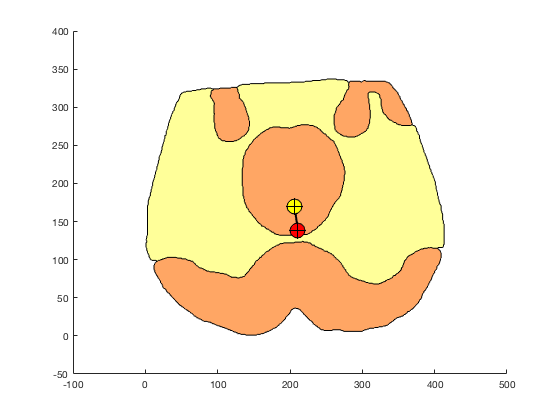

In [11]:
imatlab_export_fig('print-png') %% sets inline plotting instead of matlab's plotter

%% plot polys
ppet = plot(pet);
ppet.FaceColor = [1 1 0];
ppet.FaceAlpha = 0.4;
hold on;
pg = plot(allSpots);
pg.FaceColor = 'red';
p3.FaceAlpha = 1;
hold on;

%% plot centroids

%% make the line
plot(X, Y,...
    'LineWidth',2,...
    'Color','black');
hold on;
%% petal centroid
plot(x,y, 'o', 'MarkerSize', 15,...
    'MarkerEdgeColor','black',...
    'MarkerFaceColor','yellow')
    hold on
plot(x,y, '+', 'MarkerSize', 15,...
    'MarkerEdgeColor','black')
    hold on
   
%% polygon centroid
plot(v,w, 'o', 'MarkerSize', 15,...
    'MarkerEdgeColor','black',...
    'MarkerFaceColor','red')
    
plot(v,w, '+', 'MarkerSize', 15,...
    'MarkerEdgeColor','black')
    hold off
    